In [29]:
import os
import json
import numpy as np
import xarray as xr
import proplot as pplt
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.basemap import Basemap
from matplotlib.ticker import FuncFormatter
from matplotlib.collections import PolyCollection
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [30]:
# %config InlineBackend.figure_format = 'retina'
# plt.rcParams['font.family'] = 'Arial'
# plt.rcParams['font.size'] = 9

In [140]:
with open('/global/cfs/cdirs/m4334/sferrett/monsoon-kernels/scripts/configs.json','r',encoding='utf-8') as f:
    CONFIGS = json.load(f)
INTERIMDIR = CONFIGS['filepaths']['interim']
MODELS     = CONFIGS['models']
FIELDVARS  = CONFIGS['variables']['field']
LOCALVARS  = CONFIGS['variables']['local']
TARGETVAR  = CONFIGS['variables']['target']
LATRANGE   = CONFIGS['domain']['latrange']
LONRANGE   = CONFIGS['domain']['lonrange']
LEVRANGE   = CONFIGS['domain']['levrange']
SPLIT      = 'valid'

In [141]:
ds = xr.open_dataset(f'{INTERIMDIR}/rh.nc',engine='h5netcdf').isel(time=0)

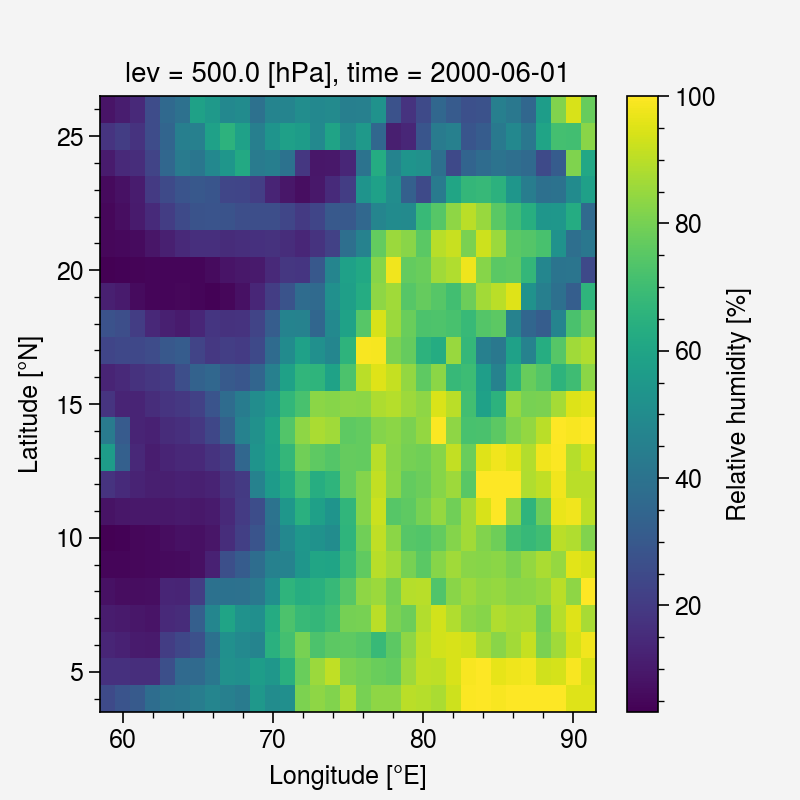

In [142]:
ds.rh.isel(lev=0).plot()

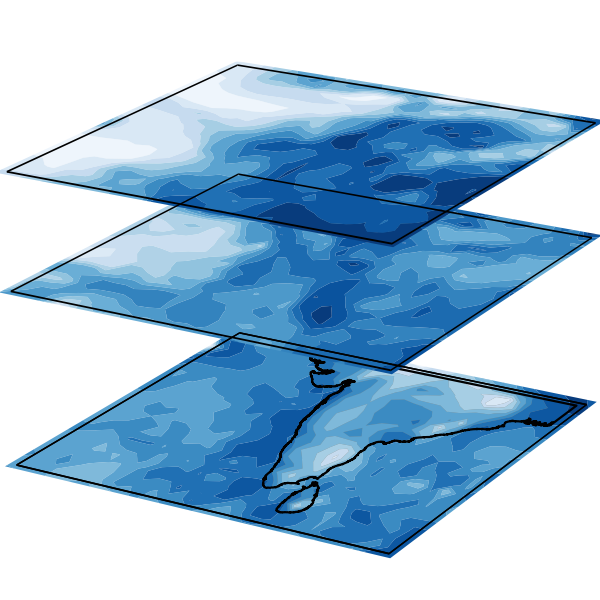

In [143]:
varname  = 'rh'
cmap     = 'Blues'
plotlevs = [1000,700,500] 
lon,lat  = np.meshgrid(ds.lon.values,ds.lat.values)

dlon = float(np.median(np.diff(ds.lon.values)))
dlat = float(np.median(np.diff(ds.lat.values)))
pad  = 0.5 * max(dlon,dlat)

def add_layer_rim(ax,lonrange,latrange,z,thickness=3.0,pad=0.0,color='k'):
    lon0,lon1 = lonrange[0]-pad,lonrange[1]+pad
    lat0,lat1 = latrange[0]-pad,latrange[1]+pad
    z0 = float(z)
    z1 = float(z)+float(thickness)
    faces = [
        [(lon0,lat0,z0),(lon1,lat0,z0),(lon1,lat0, z1),(lon0,lat0,z1)],
        [(lon1,lat0,z0),(lon1,lat1,z0),(lon1,lat1, z1),(lon1,lat0,z1)], 
        [(lon1,lat1,z0),(lon0,lat1,z0),(lon0,lat1, z1),(lon1,lat1,z1)],
        [(lon0,lat1,z0),(lon0,lat0,z0),(lon0,lat0, z1),(lon0,lat1,z1)]]
    pc = Poly3DCollection(faces,facecolor=color,edgecolor=color,linewidths=0.0)
    ax.add_collection3d(pc)

fig,ax = plt.subplots(1,1,figsize=(3,3),subplot_kw={'projection':'3d'})

m = Basemap(
    llcrnrlon=LONRANGE[0],urcrnrlon=LONRANGE[1],
    llcrnrlat=LATRANGE[0],urcrnrlat=LATRANGE[1],
    projection='cyl',resolution='i',fix_aspect=False,ax=ax)

polys = [list(p.get_coords()[:,:2])+[p.get_coords()[0,:2]] for p in m.landpolygons]
land  = PolyCollection(polys,edgecolor='k',facecolor='gray',linewidths=0.2,closed=False)
ax.add_collection3d(land,zs=LEVRANGE[1])

# --- coastline overlay: transparent faces (NOT 'none') ---
coast = PolyCollection(polys, facecolor=(0,0,0,0), edgecolor='k', linewidths=0.8, closed=False)
eps = 0.2

ax.set_proj_type('persp')
ax.set_box_aspect(None,zoom=1.1)
ax.view_init(azim=-60,elev=20)
ax.set_xlim(LONRANGE[0],LONRANGE[1])
ax.set_ylim(LATRANGE[0],LATRANGE[1])
ax.set_zlim(LEVRANGE[1],LEVRANGE[0])
ax.grid(False)
for axis in (ax.xaxis,ax.yaxis,ax.zaxis):
    axis.pane.set_visible(False)
    axis._axinfo['grid']['linewidth'] = 0
    axis.line.set_color((0,0,0,0))
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

for lev in plotlevs:
    da     = ds[varname].sel(lev=lev, method='nearest')
    values = da.values
    levs   = float(da.lev.values)

    ax.contourf(lon,lat,values,zdir='z',offset=levs,levels=10,cmap=cmap,alpha=1.0,antialiased=True)

    if np.isclose(levs, 1000.0):
        ax.add_collection3d(coast, zs=levs - eps)

    add_layer_rim(ax,LONRANGE,LATRANGE,levs,thickness=3.0,pad=pad,color='k')

add_layer_rim(ax,LONRANGE,LATRANGE,LEVRANGE[1],thickness=3.0,pad=pad,color='k')

plt.subplots_adjust(left=0,right=1,bottom=0,top=1)
plt.show()


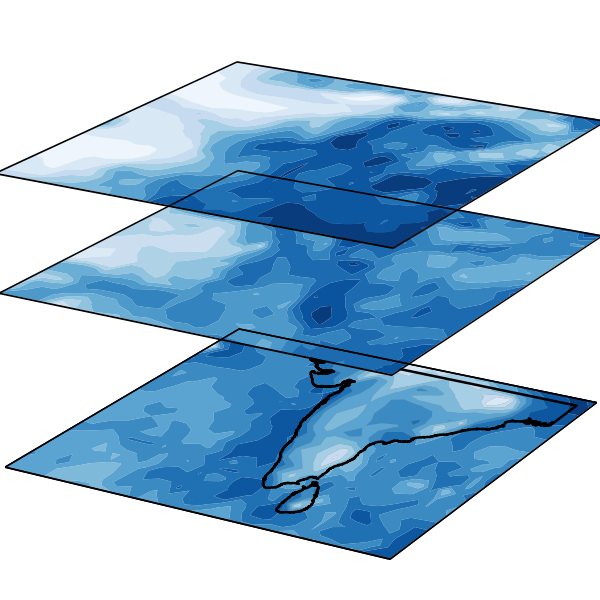

In [153]:
# Full updated version: rims align to the *visible* contour slabs,
# and coastlines overlay cleanly on the 1000 hPa slab (no more pad mismatch).

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PolyCollection
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

varname  = 'rh'
cmap     = 'Blues'
plotlevs = [1000, 700, 500]
lon2d, lat2d = np.meshgrid(ds.lon.values, ds.lat.values)

# --- IMPORTANT: make rims match what contourf visibly fills (grid-center footprint) ---
lonrange_data = (float(ds.lon.values.min()), float(ds.lon.values.max()))
latrange_data = (float(ds.lat.values.min()), float(ds.lat.values.max()))
rim_pad = 0.0  # key change: no half-grid padding for contourf slabs

def add_layer_rim(ax, lonrange, latrange, z, thickness=3.0, pad=0.0, color='k'):
    lon0, lon1 = lonrange[0] - pad, lonrange[1] + pad
    lat0, lat1 = latrange[0] - pad, latrange[1] + pad

    # Rim hangs DOWN (toward larger pressure), so it doesn't intersect planes above
    z0 = float(z)
    z1 = float(z) + float(thickness)

    faces = [
        [(lon0, lat0, z0), (lon1, lat0, z0), (lon1, lat0, z1), (lon0, lat0, z1)],  # south
        [(lon1, lat0, z0), (lon1, lat1, z0), (lon1, lat1, z1), (lon1, lat0, z1)],  # east
        [(lon1, lat1, z0), (lon0, lat1, z0), (lon0, lat1, z1), (lon1, lat1, z1)],  # north
        [(lon0, lat1, z0), (lon0, lat0, z0), (lon0, lat0, z1), (lon0, lat1, z1)],  # west
    ]
    pc = Poly3DCollection(faces, facecolor=color, edgecolor=color, linewidths=0.0)
    ax.add_collection3d(pc)

fig, ax = plt.subplots(1, 1, figsize=(3, 3), subplot_kw={'projection': '3d'})

# --- Basemap land polygons on the floor ---
m = Basemap(
    llcrnrlon=LONRANGE[0], urcrnrlon=LONRANGE[1],
    llcrnrlat=LATRANGE[0], urcrnrlat=LATRANGE[1],
    projection='cyl', resolution='i', fix_aspect=False, ax=ax
)
polys = [list(p.get_coords()[:, :2]) + [p.get_coords()[0, :2]] for p in m.landpolygons]

land = PolyCollection(polys, edgecolor='k', facecolor='gray', linewidths=0.2, closed=False)
ax.add_collection3d(land, zs=LEVRANGE[1])

# --- Coastline-only overlay artist (transparent faces, black edges) ---
coast = PolyCollection(polys, facecolor=(0, 0, 0, 0), edgecolor='k', linewidths=0.9, closed=False)
eps = 0.2  # tiny lift above the 1000 hPa slab (reversed z-axis => subtract lifts)

# --- 3D formatting ---
ax.set_proj_type('persp')
ax.set_box_aspect(None, zoom=1.1)
ax.view_init(azim=-60, elev=20)

ax.set_xlim(LONRANGE[0], LONRANGE[1])
ax.set_ylim(LATRANGE[0], LATRANGE[1])
ax.set_zlim(LEVRANGE[1], LEVRANGE[0])  # reverse pressure axis

# remove panes, grids, axis lines
ax.grid(False)
for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
    axis.pane.set_visible(False)
    axis._axinfo['grid']['linewidth'] = 0
    axis.line.set_color((0, 0, 0, 0))
ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

# --- plot layers + rims ---
for lev in plotlevs:
    da     = ds[varname].sel(lev=lev, method='nearest')
    values = da.values
    z      = float(da.lev.values)

    ax.contourf(
        lon2d, lat2d, values,
        zdir='z', offset=z,
        levels=10, cmap=cmap,
        alpha=1.0, antialiased=True
    )

    # Coastline on top of the 1000 hPa slab
    if np.isclose(z, 1000.0):
        ax.add_collection3d(coast, zs=z - eps)

    # Rim aligned to the visible slab footprint (no pad)
    add_layer_rim(ax, lonrange_data, latrange_data, z, thickness=3.0, pad=rim_pad, color='k')

# Optional: floor rim (comment out if you don't want it)
add_layer_rim(ax, lonrange_data, latrange_data, LEVRANGE[1], thickness=3.0, pad=rim_pad, color='k')

plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.show()


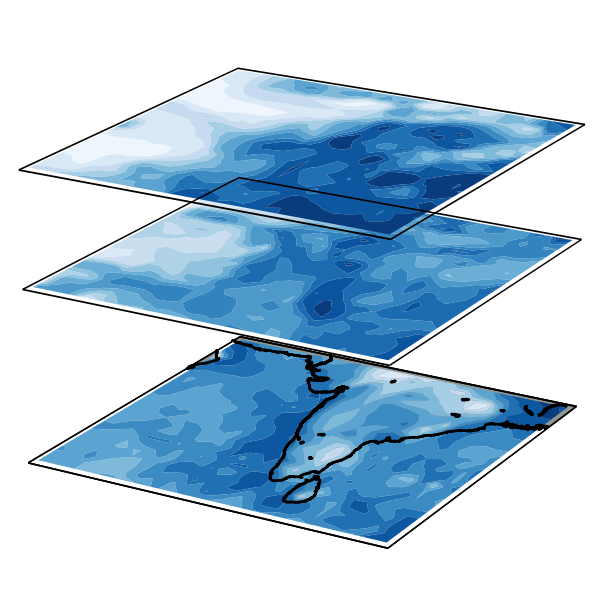

In [154]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PolyCollection
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

varname  = 'rh'
cmap     = 'Blues'
plotlevs = [1000, 700, 500]
lon2d, lat2d = np.meshgrid(ds.lon.values, ds.lat.values)

# --- TRUE cell edges for a center-defined 1° grid (centers ± 0.5°) ---
dlon = float(np.median(np.diff(ds.lon.values)))
dlat = float(np.median(np.diff(ds.lat.values)))
lon_edges = np.concatenate(([ds.lon.values[0] - 0.5*dlon], ds.lon.values[:-1] + 0.5*dlon, [ds.lon.values[-1] + 0.5*dlon]))
lat_edges = np.concatenate(([ds.lat.values[0] - 0.5*dlat], ds.lat.values[:-1] + 0.5*dlat, [ds.lat.values[-1] + 0.5*dlat]))
lonrange_edge = (float(lon_edges.min()), float(lon_edges.max()))
latrange_edge = (float(lat_edges.min()), float(lat_edges.max()))
rim_pad = 0.0  # already accounted for via edges

def add_layer_rim(ax, lonrange, latrange, z, thickness=3.0, pad=0.0, color='k'):
    lon0, lon1 = lonrange[0] - pad, lonrange[1] + pad
    lat0, lat1 = latrange[0] - pad, latrange[1] + pad
    z0 = float(z)
    z1 = float(z) + float(thickness)  # hangs DOWN (toward larger pressure)

    faces = [
        [(lon0, lat0, z0), (lon1, lat0, z0), (lon1, lat0, z1), (lon0, lat0, z1)],  # south
        [(lon1, lat0, z0), (lon1, lat1, z0), (lon1, lat1, z1), (lon1, lat0, z1)],  # east
        [(lon1, lat1, z0), (lon0, lat1, z0), (lon0, lat1, z1), (lon1, lat1, z1)],  # north
        [(lon0, lat1, z0), (lon0, lat0, z0), (lon0, lat0, z1), (lon0, lat1, z1)],  # west
    ]
    pc = Poly3DCollection(faces, facecolor=color, edgecolor=color, linewidths=0.0)
    ax.add_collection3d(pc)

fig, ax = plt.subplots(1, 1, figsize=(3, 3), subplot_kw={'projection': '3d'})

# --- Basemap used only as a geometry source; use TRUE EDGE bounds for ll/ur corners ---
m = Basemap(
    llcrnrlon=lonrange_edge[0], urcrnrlon=lonrange_edge[1],
    llcrnrlat=latrange_edge[0], urcrnrlat=latrange_edge[1],
    projection='cyl', resolution='i', fix_aspect=False, ax=ax
)

# land polygons (floor fill)
polys = [list(p.get_coords()[:, :2]) + [p.get_coords()[0, :2]] for p in m.landpolygons]
land = PolyCollection(polys, edgecolor='k', facecolor='gray', linewidths=0.2, closed=False)
ax.add_collection3d(land, zs=LEVRANGE[1])

# --- Coastline-only overlay: use *coastsegs* (lines), not land polygon edges ---
# This matches "coastline" better and doesn't inherit polygon closure artifacts.
eps = 0.2  # lift above 1000 hPa slab (reversed z-axis => subtract lifts)
segments3d = []
for seg in m.coastsegs:
    seg = np.asarray(seg)
    if seg.ndim != 2 or seg.shape[1] != 2:
        continue
    x, y = seg[:, 0], seg[:, 1]
    mask = (x >= lonrange_edge[0]) & (x <= lonrange_edge[1]) & (y >= latrange_edge[0]) & (y <= latrange_edge[1])
    if mask.sum() < 2:
        continue
    # z is filled in later (at 1000 hPa)
    segments3d.append(np.column_stack([x[mask], y[mask]]))

# --- 3D formatting ---
ax.set_proj_type('persp')
ax.set_box_aspect(None, zoom=1.1)
ax.view_init(azim=-60, elev=20)

# use TRUE EDGE bounds so slab/rim matches the domain box
ax.set_xlim(lonrange_edge[0], lonrange_edge[1])
ax.set_ylim(latrange_edge[0], latrange_edge[1])
ax.set_zlim(LEVRANGE[1], LEVRANGE[0])  # reverse pressure axis

ax.grid(False)
for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
    axis.pane.set_visible(False)
    axis._axinfo['grid']['linewidth'] = 0
    axis.line.set_color((0, 0, 0, 0))
ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

# --- plot layers + rims ---
for lev in plotlevs:
    da     = ds[varname].sel(lev=lev, method='nearest')
    values = da.values
    z      = float(da.lev.values)

    ax.contourf(
        lon2d, lat2d, values,
        zdir='z', offset=z,
        levels=10, cmap=cmap,
        alpha=1.0, antialiased=True
    )

    # Coastline on top of the 1000 hPa slab (as line segments)
    if np.isclose(z, 1000.0) and segments3d:
        segs3d_z = [np.column_stack([seg[:, 0], seg[:, 1], np.full(seg.shape[0], z - eps)]) for seg in segments3d]
        ax.add_collection3d(Line3DCollection(segs3d_z, colors='k', linewidths=1.0))

    # Rim aligned to TRUE cell-edge footprint
    add_layer_rim(ax, lonrange_edge, latrange_edge, z, thickness=3.0, pad=rim_pad, color='k')

# Optional: floor rim (comment out if you don't want it)
add_layer_rim(ax, lonrange_edge, latrange_edge, LEVRANGE[1], thickness=3.0, pad=rim_pad, color='k')

plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.show()


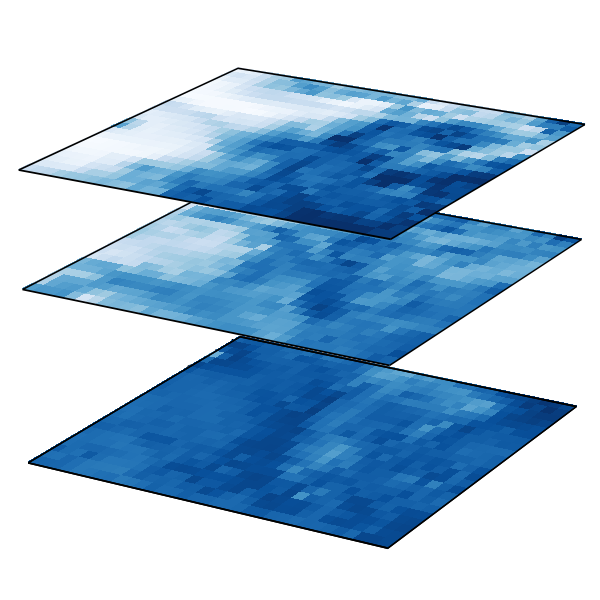

In [156]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PolyCollection
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import matplotlib.colors as mcolors

varname  = 'rh'
cmap     = 'blues'
plotlevs = [1000, 700, 500]

# --- TRUE cell edges for a center-defined 1° grid (centers ± 0.5°) ---
dlon = float(np.median(np.diff(ds.lon.values)))
dlat = float(np.median(np.diff(ds.lat.values)))
lon_edges = np.concatenate(([ds.lon.values[0] - 0.5*dlon], ds.lon.values[:-1] + 0.5*dlon, [ds.lon.values[-1] + 0.5*dlon]))
lat_edges = np.concatenate(([ds.lat.values[0] - 0.5*dlat], ds.lat.values[:-1] + 0.5*dlat, [ds.lat.values[-1] + 0.5*dlat]))
lonrange_edge = (float(lon_edges.min()), float(lon_edges.max()))
latrange_edge = (float(lat_edges.min()), float(lat_edges.max()))

# edge meshes for plot_surface (nlat+1, nlon+1)
LONe, LATe = np.meshgrid(lon_edges, lat_edges)

def add_layer_rim(ax, lonrange, latrange, z, thickness=3.0, color='k'):
    lon0, lon1 = lonrange
    lat0, lat1 = latrange
    z0 = float(z)
    z1 = float(z) + float(thickness)  # hangs DOWN (toward larger pressure)
    faces = [
        [(lon0, lat0, z0), (lon1, lat0, z0), (lon1, lat0, z1), (lon0, lat0, z1)],
        [(lon1, lat0, z0), (lon1, lat1, z0), (lon1, lat1, z1), (lon1, lat0, z1)],
        [(lon1, lat1, z0), (lon0, lat1, z0), (lon0, lat1, z1), (lon1, lat1, z1)],
        [(lon0, lat1, z0), (lon0, lat0, z0), (lon0, lat0, z1), (lon0, lat1, z1)],
    ]
    ax.add_collection3d(Poly3DCollection(faces, facecolor=color, edgecolor=color, linewidths=0.0))

fig, ax = plt.subplots(1, 1, figsize=(3, 3), subplot_kw={'projection': '3d'})

# --- Basemap geometry source using TRUE EDGE bounds ---
m = Basemap(
    llcrnrlon=lonrange_edge[0], urcrnrlon=lonrange_edge[1],
    llcrnrlat=latrange_edge[0], urcrnrlat=latrange_edge[1],
    projection='cyl', resolution='i', fix_aspect=False, ax=ax
)

# floor land fill
polys = [list(p.get_coords()[:, :2]) + [p.get_coords()[0, :2]] for p in m.landpolygons]
land = PolyCollection(polys, edgecolor='k', facecolor='gray', linewidths=0.2, closed=False)
ax.add_collection3d(land, zs=LEVRANGE[1])

# coastline segments as lines
eps = 0.2
segments2d = []
for seg in m.coastsegs:
    seg = np.asarray(seg)
    if seg.ndim != 2 or seg.shape[1] != 2:
        continue
    x, y = seg[:, 0], seg[:, 1]
    mask = (x >= lonrange_edge[0]) & (x <= lonrange_edge[1]) & (y >= latrange_edge[0]) & (y <= latrange_edge[1])
    if mask.sum() < 2:
        continue
    segments2d.append(np.column_stack([x[mask], y[mask]]))

# --- 3D formatting ---
ax.set_proj_type('persp')
ax.set_box_aspect(None, zoom=1.1)
ax.view_init(azim=-60, elev=20)
ax.set_xlim(lonrange_edge[0], lonrange_edge[1])
ax.set_ylim(latrange_edge[0], latrange_edge[1])
ax.set_zlim(LEVRANGE[1], LEVRANGE[0])  # reverse pressure axis

ax.grid(False)
for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
    axis.pane.set_visible(False)
    axis._axinfo['grid']['linewidth'] = 0
    axis.line.set_color((0, 0, 0, 0))
ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

# --- shared normalization so colors are consistent across levels ---
vals_all = []
das = []
for lev in plotlevs:
    da = ds[varname].sel(lev=lev, method='nearest')
    das.append(da)
    v = da.values
    vals_all.append(v[np.isfinite(v)].ravel())
vals_all = np.concatenate(vals_all)
norm = mcolors.Normalize(vmin=float(vals_all.min()), vmax=float(vals_all.max()))
cmap_obj = plt.get_cmap(cmap)

# --- plot layers as TRUE edge-filling surfaces + rims ---
for da in das:
    z = float(da.lev.values)
    cell = np.ma.masked_invalid(da.values)  # (nlat, nlon)

    # facecolors per cell quad must be (nlat, nlon, 4)
    facecolors = cmap_obj(norm(cell))

    Ze = np.full_like(LONe, z, dtype=float)  # (nlat+1, nlon+1)

    ax.plot_surface(
        LONe, LATe, Ze,
        facecolors=facecolors,
        rstride=1, cstride=1,
        linewidth=0, antialiased=False, shade=False
    )

    # coastline on top of 1000 hPa slab
    if np.isclose(z, 1000.0) and segments2d:
        segs3d = [np.column_stack([seg[:, 0], seg[:, 1], np.full(seg.shape[0], z - eps)]) for seg in segments2d]
        ax.add_collection3d(Line3DCollection(segs3d, colors='k', linewidths=1.0))

    add_layer_rim(ax, lonrange_edge, latrange_edge, z, thickness=3.0, color='k')

# Optional: floor rim
add_layer_rim(ax, lonrange_edge, latrange_edge, LEVRANGE[1], thickness=3.0, color='k')

plt.subplots_adjust(left=0,right=1,bottom=0, top=1)
plt.show()